In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import control 
import sys
import networkx as nx




In [2]:
class MyNN(nn.Module):
    #do variable length hidden layers
    #output and input layer do not have activation functions
    def __init__(self, input_size, num_hidden_layers, hidden_size, output_size):
        super(MyNN, self).__init__()
        layers = []
        for i in range(num_hidden_layers):
            in_features = input_size if i == 0 else hidden_size
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)



In [3]:
#Easy control system
def lyapunov(x):
    return 0.5 * (x - 1)**2
def f(x): #x dot
    return 1-x

def train_model(x_train, y_train, model, num_epochs=1000, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

MyNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)
Epoch [100/1000], Loss: 0.0099
Epoch [200/1000], Loss: 0.0065
Epoch [300/1000], Loss: 0.0046
Epoch [400/1000], Loss: 0.0032
Epoch [500/1000], Loss: 0.0022
Epoch [600/1000], Loss: 0.0016
Epoch [700/1000], Loss: 0.0012
Epoch [800/1000], Loss: 0.0009
Epoch [900/1000], Loss: 0.0007
Epoch [1000/1000], Loss: 0.0006


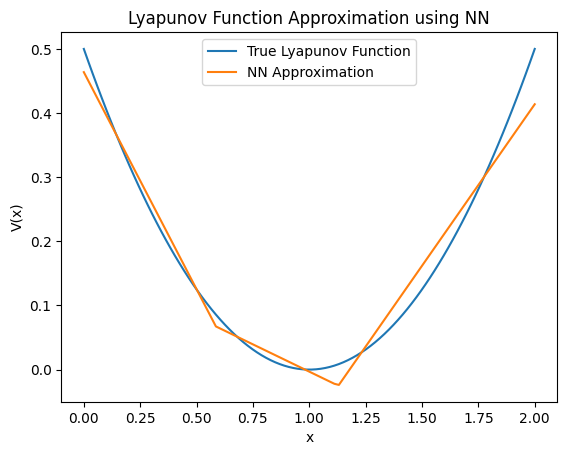

In [4]:
#1-2-1 nn with ReLU activations and 2 n in hidden
one_two_one_nn = MyNN(input_size=1, num_hidden_layers=1, hidden_size=4, output_size=1)
print(one_two_one_nn)
#can this approximate a lyapunov function for a simple system?
#i.e. \dot{x} = f(x) = 
# V(x) = 1/2 (x - 1)^2
#train to approximate V
#get training data
x_train = torch.linspace(0, 2, steps=100).view(-1, 1)
y_train = lyapunov(x_train).view(-1, 1)
#train nn
one_two_one_nn = train_model(x_train, y_train, one_two_one_nn, num_epochs=1000, learning_rate=0.01)


#compare the function vs the nn approximation
x_test = torch.linspace(0, 2, steps=100).view(-1, 1)
y_test = lyapunov(x_test).view(-1, 1)
y_nn = one_two_one_nn(x_test).detach().numpy()
plt.plot(x_test.numpy(), y_test.numpy(), label='True Lyapunov Function')
plt.plot(x_test.numpy(), y_nn, label='NN Approximation')
plt.legend()
plt.xlabel('x')
plt.ylabel('V(x)')
plt.title('Lyapunov Function Approximation using NN')
plt.show()

/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_15377/1340099131.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V_grad = float(np.dot(vec_2.T, vec_1))


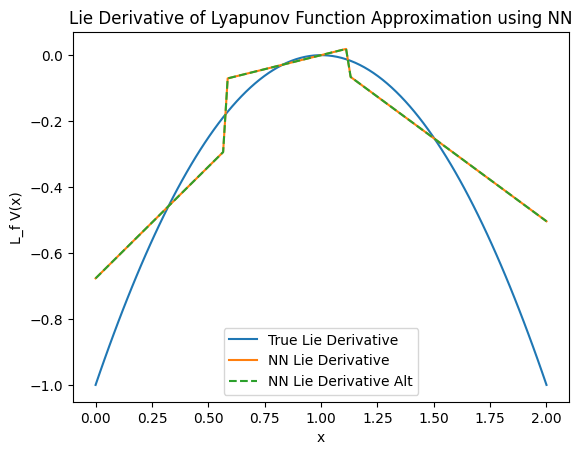

In [5]:
#plot the lie derivative of the true lyapunov function vs the nn approximation
def lie_derivative_nn(x, V, f):
    V_grad = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    return V_grad * f(x) 

def lie_derivative_true(x):
    V_grad = x - 1
    return V_grad * f(x)

def step_function(x):
    if x >= 0:
        return 1
    else:
        return 0

def V_dot(x, model): #the dot product form I derived in my notes
    hidden_linear = model.network[0]
    output_linear = model.network[2]
    n = hidden_linear.out_features
    vec_1 = np.zeros((n, 1))
    vec_2 = np.zeros((n, 1))
    for i in range(n):
        w1 = hidden_linear.weight[i, 0].item()
        b1 = hidden_linear.bias[i].item()
        w2 = output_linear.weight[0, i].item()
        vec_1[i] = step_function(w1 * x + b1)
        vec_2[i] = w1 * w2
    V_grad = float(np.dot(vec_2.T, vec_1))
    return V_grad * f(x)

y_lie_true = lie_derivative_true(x_test).view(-1, 1).detach().numpy()
x_test.requires_grad = True
y_nn = one_two_one_nn(x_test)
y_lie_nn = lie_derivative_nn(x_test, y_nn, f).view(-1, 1).detach().numpy()
#also plot alternative V_dot to make sure they are the same
y_lie_nn_alt = np.zeros_like(y_lie_nn)
x_test_floats = x_test.detach().numpy().flatten()
for i in range(x_test.shape[0]):
    y_lie_nn_alt[i] = V_dot(float(x_test_floats[i]), one_two_one_nn)
#check they are the same
plt.figure()
plt.plot(x_test.detach().numpy(), y_lie_true, label='True Lie Derivative')
plt.plot(x_test.detach().numpy(), y_lie_nn, label='NN Lie Derivative')
plt.plot(x_test.detach().numpy(), y_lie_nn_alt, label='NN Lie Derivative Alt', linestyle='dashed')
plt.legend()
plt.xlabel('x')
plt.ylabel('L_f V(x)')
plt.title('Lie Derivative of Lyapunov Function Approximation using NN')
plt.show()

In [6]:

# print(one_two_one_nn.network[0].weight)
# print(one_two_one_nn.network[2].weight)
# print(torch.Tensor([[1], [2]]))
#print the weights and biases
print(one_two_one_nn.network)
print("Weights and biases of the trained NN:")
print(one_two_one_nn.network[0].weight)
print(one_two_one_nn.network[0].bias)
print(one_two_one_nn.network[1])  # This will print the ReLU layer
print(one_two_one_nn.network[2].weight)
print(one_two_one_nn.network[2].bias)

Sequential(
  (0): Linear(in_features=1, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=1, bias=True)
)
Weights and biases of the trained NN:
Parameter containing:
tensor([[-0.2223],
        [-0.9475],
        [ 0.8381],
        [ 0.2576]], requires_grad=True)
Parameter containing:
tensor([ 0.5724,  1.0697, -0.4909,  0.8136], requires_grad=True)
ReLU()
Parameter containing:
tensor([[-0.0584,  0.7113,  0.6046, -0.0615]], requires_grad=True)
Parameter containing:
tensor([-0.2136], requires_grad=True)


In [7]:
#takes in model, num of input neurons, num of hidden neurons, and list of functions that represent dynamical system
#outputs v dot at some x
def my_result(model, input_num, hidden_num, F_func_list, x_state):
    #first collect the edges into appropriate matrices to access
    W_matrix  = model.network[0].weight.detach().numpy().T #each column is weights into a hidden neuron [w1, w2,..., wn; w_n+1, ...]
    B_vector  = model.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
    W_out_vec = model.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
    #W_out_vec = W_out_vec[::-1]
    W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
    #compute activation vector at x_state: This is a stationary vector for any x_state
    A_vector = np.zeros((hidden_num, 1))
    for i in range(hidden_num):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        A_vector[i] = step_function(np.dot(w_i, x_state) + b_i)
    
    #now loop through each function in F_func_list and multiply by the dot product form
    sum = 0
    for i in range(input_num):
        F_i = F_func_list[i]
        f_i_x = F_i(x_state)
        #compute V_dot contribution from this f_i
        this_w_vec = W_out_matrix @ W_matrix[i, :].reshape(-1, 1)
        sum = sum + f_i_x * np.dot(A_vector.T, this_w_vec)
    return sum






Epoch [100/5000], Loss: 0.0086
Epoch [200/5000], Loss: 0.0021
Epoch [300/5000], Loss: 0.0007
Epoch [400/5000], Loss: 0.0004
Epoch [500/5000], Loss: 0.0003
Epoch [600/5000], Loss: 0.0002
Epoch [700/5000], Loss: 0.0002
Epoch [800/5000], Loss: 0.0002
Epoch [900/5000], Loss: 0.0001
Epoch [1000/5000], Loss: 0.0001
Epoch [1100/5000], Loss: 0.0001
Epoch [1200/5000], Loss: 0.0001
Epoch [1300/5000], Loss: 0.0001
Epoch [1400/5000], Loss: 0.0001
Epoch [1500/5000], Loss: 0.0001
Epoch [1600/5000], Loss: 0.0001
Epoch [1700/5000], Loss: 0.0001
Epoch [1800/5000], Loss: 0.0001
Epoch [1900/5000], Loss: 0.0001
Epoch [2000/5000], Loss: 0.0001
Epoch [2100/5000], Loss: 0.0001
Epoch [2200/5000], Loss: 0.0001
Epoch [2300/5000], Loss: 0.0001
Epoch [2400/5000], Loss: 0.0001
Epoch [2500/5000], Loss: 0.0001
Epoch [2600/5000], Loss: 0.0001
Epoch [2700/5000], Loss: 0.0000
Epoch [2800/5000], Loss: 0.0000
Epoch [2900/5000], Loss: 0.0000
Epoch [3000/5000], Loss: 0.0000
Epoch [3100/5000], Loss: 0.0000
Epoch [3200/5000]

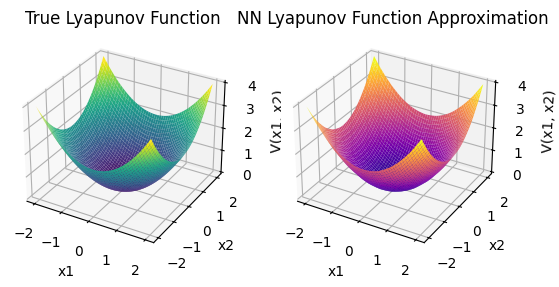

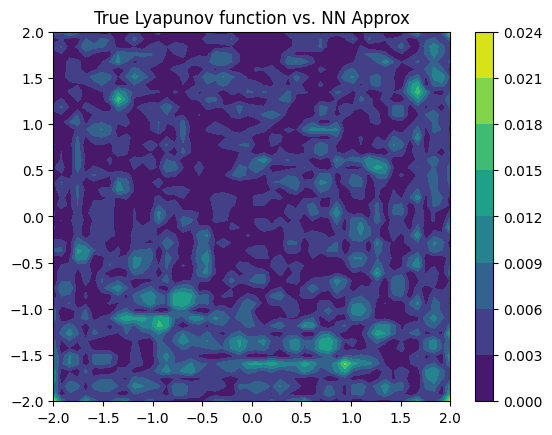

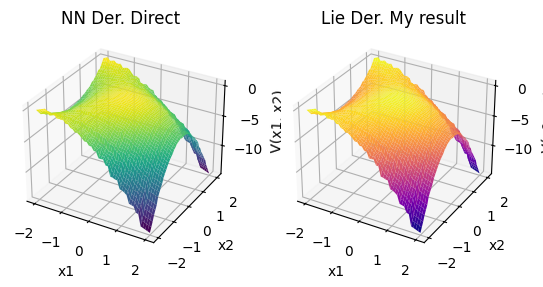

Text(0.5, 1.0, 'Torch Lie vs. My Lie')

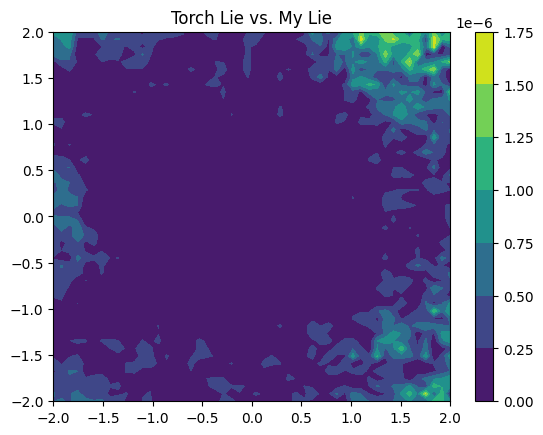

In [8]:
#a dynamical system to test out
def f_1(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return -x1 - x2**2
def f_2(x):
    x2 = x[1, 0]
    return -x2

def V_analytic(x1, x2):
    return 0.5 * (x1**2 + x2**2)
#caluclate the lie derivative with the gradients in torch
def torch_lie_derivative(f_1, f_2, x):
    V_grad = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    
#now approximate the lyapunov function with a nn
two_n_one_nn = MyNN(input_size=2, num_hidden_layers=1, hidden_size=100, output_size=1)
x1_train = torch.linspace(-2, 2, steps=50)
x2_train = torch.linspace(-2, 2, steps=50)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = V_analytic(x_train_2d[:,0], x_train_2d[:,1]).view(-1, 1)
#train nn
two_n_one_nn = train_model(x_train_2d, y_train_2d, two_n_one_nn, num_epochs=5000, learning_rate=0.01)

#plot the true vs nn lyapunov function on a grid
x1_test = torch.linspace(-2, 2, steps=50)
x2_test = torch.linspace(-2, 2, steps=50)
x1_grid_test, x2_grid_test = torch.meshgrid(x1_test, x2_test, indexing='ij')
x_test_2d = torch.stack([x1_grid_test.flatten(), x2_grid_test.flatten()], dim=1)
y_test_2d = V_analytic(x_test_2d[:,0], x_test_2d[:,1]).view(-1, 1)
y_nn_2d = two_n_one_nn(x_test_2d).detach().numpy()
#reshape for plotting
y_test_2d = y_test_2d.view(50, 50).detach().numpy()
y_nn_2d = y_nn_2d.reshape(50, 50)

#plot both on the same plot in 3d but different styles
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_test_2d, cmap='viridis')
ax.set_title('True Lyapunov Function')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('V(x1, x2)')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_nn_2d, cmap='plasma')
ax2.set_title('NN Lyapunov Function Approximation')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('V(x1, x2)')
plt.show()  

#also plot the error between the two
fig = plt.figure()
errors = np.abs(y_test_2d - y_nn_2d)
cp = plt.contourf(x1_grid_test.numpy(), x2_grid_test.numpy(), errors)
cb = plt.colorbar(cp)
plt.title("True Lyapunov function vs. NN Approx")


#now plot the lie derivative of both
F_func_list = [f_1, f_2]
y_lie_nn_grad_2d = np.zeros((50, 50))
y_lie_my_result = np.zeros((50, 50))
for i in range(50):
    for j in range(50):
        x_state = x_test_2d[i*50 + j].unsqueeze(0).clone().detach().requires_grad_(True)
        
        # Get the NN output and compute gradient
        V_nn = two_n_one_nn(x_state)
        V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
        
        # Evaluate the dynamical system at this point
        x_state_flat = x_state.detach().squeeze(0).unsqueeze(1)
        f_1_val = f_1(x_state_flat)
        f_2_val = f_2(x_state_flat)
        
        # Compute Lie derivative: grad(V) · f(x)
        lie_deriv = V_grad[0, 0] * f_1_val + V_grad[0, 1] * f_2_val
        y_lie_nn_grad_2d[i, j] = lie_deriv.item()

        #also compute using my_result function for verification
        y_lie_my_result[i, j] = my_result(two_n_one_nn, 2, 100, F_func_list, x_state_flat)
        

#plot both lie derivatives to compare in 3d
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_lie_nn_grad_2d, cmap='viridis')
ax.set_title('NN Der. Direct ')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('V(x1, x2)')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x1_grid_test.numpy(), x2_grid_test.numpy(), y_lie_my_result, cmap='plasma')
ax2.set_title('Lie Der. My result')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('V(x1, x2)')
plt.show()  



#also plot the error between the two
fig = plt.figure()
errors_lie = np.abs(y_lie_my_result - y_lie_nn_grad_2d)
cp = plt.contourf(x1_grid_test.numpy(), x2_grid_test.numpy(), errors_lie)
cb = plt.colorbar(cp)
plt.title("Torch Lie vs. My Lie")


In [9]:
print("weights and biases of the trained 2-4-1 NN:")
print(two_n_one_nn.network)
print("Weights and biases of the trained NN:")
print(two_n_one_nn.network[0].weight)

print(two_n_one_nn.network[0].bias)
print(two_n_one_nn.network[1])  # This will print the ReLU layer
print(two_n_one_nn.network[2].weight)
print(two_n_one_nn.network[2].bias) 

weights and biases of the trained 2-4-1 NN:
Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)
Weights and biases of the trained NN:
Parameter containing:
tensor([[-4.1323e-01,  7.4886e-01],
        [-4.3929e-01,  1.0357e-03],
        [ 3.4202e-02,  7.2629e-01],
        [ 2.5493e-01,  4.4403e-03],
        [-5.9640e-01, -2.0523e-02],
        [-7.9873e-02,  6.9786e-03],
        [-5.3514e-01,  4.9588e-01],
        [ 1.3639e-01, -6.8012e-01],
        [-1.9754e-01, -7.0219e-01],
        [ 5.0597e-02,  7.0835e-01],
        [ 7.0407e-01, -3.0532e-02],
        [ 1.8567e-01,  5.6551e-02],
        [ 5.5509e-01,  3.5277e-02],
        [-8.1053e-02, -1.2908e-01],
        [-6.7402e-02,  5.7209e-01],
        [-4.3505e-01, -2.7120e-01],
        [-2.1956e-02,  4.4974e-01],
        [ 4.8174e-01, -3.7564e-01],
        [-4.5066e-02, -3.9518e-01],
        [ 1.2876e-01, -7.0250e-01],
        [-6.7822e-01, -8.1779e-0

In [10]:
#make numpy matrix
print(two_n_one_nn.network[2].weight.detach().numpy().T)
print(np.diag(two_n_one_nn.network[2].weight.detach().numpy().flatten()))

[[ 1.35454178e-01]
 [ 1.85538307e-01]
 [ 1.91126525e-01]
 [-9.90740880e-02]
 [ 2.97791719e-01]
 [-4.30870578e-02]
 [ 6.69397339e-02]
 [ 1.11508816e-01]
 [ 1.06013499e-01]
 [ 8.38795751e-02]
 [ 1.02643348e-01]
 [-1.14798225e-01]
 [ 1.42324969e-01]
 [-9.62282415e-04]
 [ 2.15651155e-01]
 [-4.69979718e-02]
 [ 1.90603495e-01]
 [-5.94954714e-02]
 [ 3.63528371e-01]
 [ 2.10260227e-01]
 [ 1.57301128e-01]
 [ 6.72919452e-02]
 [ 1.37593020e-02]
 [ 5.12769878e-01]
 [ 9.82427225e-02]
 [ 2.44370162e-01]
 [ 6.68010041e-02]
 [ 1.39660612e-01]
 [-1.28061116e-01]
 [ 1.24993436e-01]
 [-5.50824031e-02]
 [ 2.10108981e-01]
 [ 2.16515690e-01]
 [ 5.12975603e-02]
 [ 8.18407387e-02]
 [ 3.41480196e-01]
 [ 3.86190683e-01]
 [ 1.89036250e-01]
 [ 1.17036089e-01]
 [-7.18774423e-02]
 [ 2.94792891e-01]
 [ 3.56961012e-01]
 [ 7.53171518e-02]
 [ 2.20347434e-01]
 [ 3.30282837e-01]
 [ 3.07476282e-01]
 [ 7.85775036e-02]
 [ 6.11414090e-02]
 [ 6.65480852e-01]
 [ 2.76311152e-02]
 [-1.35423347e-01]
 [ 2.67310679e-01]
 [ 1.6989700

Simple Example in $\mathbb{R}^2$

Simple NN Epoch [100/1000], Loss: 0.1378
Simple NN Epoch [200/1000], Loss: 0.1378
Simple NN Epoch [300/1000], Loss: 0.1378
Simple NN Epoch [400/1000], Loss: 0.1378
Simple NN Epoch [500/1000], Loss: 0.1378
Simple NN Epoch [600/1000], Loss: 0.1378
Simple NN Epoch [700/1000], Loss: 0.1378
Simple NN Epoch [800/1000], Loss: 0.1378
Simple NN Epoch [900/1000], Loss: 0.1378
Simple NN Epoch [1000/1000], Loss: 0.1378


/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_15377/1957142679.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x_vec.T @ P @ x_vec)


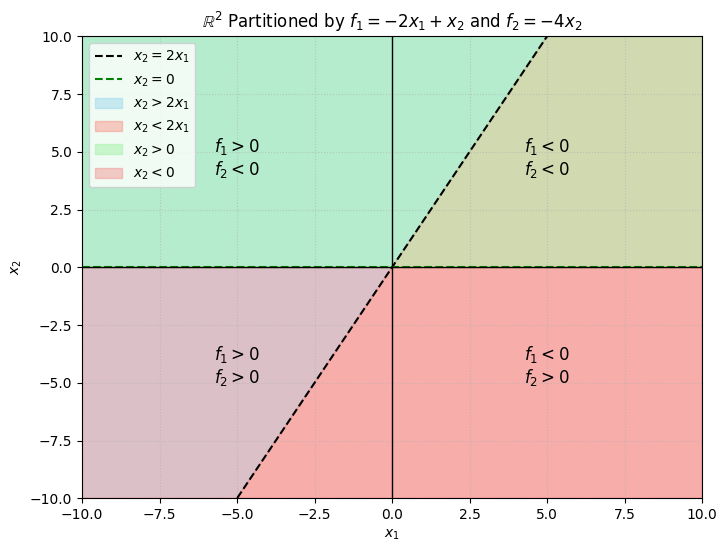

In [11]:

def simple_f1(x1, x2):
    return -2*x1 + x2
def simple_f2(x1, x2):
    return -4*x2

#build and train a simple nn, 2- 2- 1
simple_nn = MyNN(input_size=2, num_hidden_layers=1, hidden_size=2, output_size=1)
A = np.array([[-2, 1], [0, -4]])
Q = np.eye(2)
P = control.lyap(A.T, Q) #this is the P for V = x^T P x
#use P to make training data
def V_linear(x1, x2):
    x_vec = np.array([[x1], [x2]])
    return float(x_vec.T @ P @ x_vec)

#train nn
x1_train = torch.linspace(-2, 2, steps=50)
x2_train = torch.linspace(-2, 2, steps=50)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = torch.tensor([V_linear(x1.item(), x2.item()) for x1, x2 in zip(x_train_2d[:,0], x_train_2d[:,1])]).view(-1, 1)
#train nn
criterion_simple = nn.MSELoss()
optimizer_simple = torch.optim.Adam(simple_nn.parameters(), lr=0.01)
num_epochs_simple = 1000
for epoch in range(num_epochs_simple):
    optimizer_simple.zero_grad()
    outputs_simple = simple_nn(x_train_2d)
    loss_simple = criterion_simple(outputs_simple, y_train_2d)
    loss_simple.backward()
    optimizer_simple.step()
    if (epoch+1) % 100 == 0:
        print(f'Simple NN Epoch [{epoch+1}/{num_epochs_simple}], Loss: {loss_simple.item():.4f}')



#plot the positive and negative regions for f_1 and f_2

# 1. Setup the data
x1 = np.linspace(-10, 10, 100)
x2_boundary = 2*x1
f2_boundary = 0
# 2. Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# 3. Plot the boundary line (Dashed indicates strict inequality)
ax.plot(x1, x2_boundary, color='black', linestyle='--', linewidth=1.5, label='$x_2 = 2x_1$')
ax.plot(x1, f2_boundary * np.ones_like(x1), color='green', linestyle='--', linewidth=1.5, label='$x_2 = 0$')

ax.fill_between(x1, x2_boundary, 10, color='skyblue', alpha=0.4, label='$x_2 > 2x_1$')
ax.fill_between(x1, x2_boundary, -10, color='salmon', alpha=0.4, label='$x_2 < 2x_1$')
ax.fill_between(x1, f2_boundary, 10, color='lightgreen', alpha=0.4, label='$x_2 > 0$')
ax.fill_between(x1, f2_boundary, -10, color='lightcoral', alpha=0.4, label='$x_2 < 0$')

# Place text at a specific coordinate
ax.text(-5, 5, "$f_1 > 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(-5, 4, "$f_2 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, 5, "$f_1 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, 4, "$f_2 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(-5, -4, "$f_1 > 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(-5, -5, "$f_2 > 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, -4, "$f_1 < 0 $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, -5, "$f_2 > 0 $", fontsize=12, fontweight='bold', ha='center')

# 6. Formatting the plot
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axhline(0, color='black', lw=1) # X-axis line
ax.axvline(0, color='black', lw=1) # Y-axis line
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$\mathbb{R}^2$ Partitioned by $f_1 = -2x_1 + x_2$ and $f_2 = -4x_2$')

# 7. Add the legend
ax.legend(loc='upper left', frameon=True)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()





The Neurons in the Hidden Layer also Partition the State Space

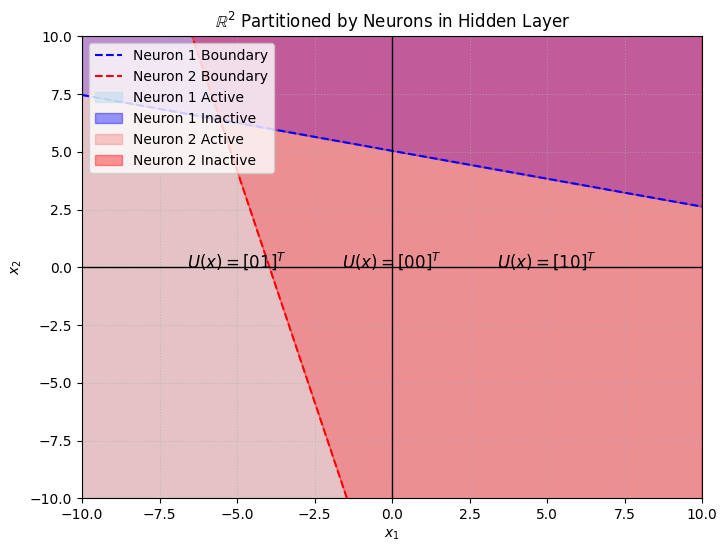

In [12]:
#Okay now we need to plot the regions of U(x), where 
W_matrix  = simple_nn.network[0].weight.detach().numpy().T
B_vector  = simple_nn.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
W_out_vec = simple_nn.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
#compute activation vector at x_state: This is a stationary vector for any x_state
hidden_num = 2
x_state = np.array([[1], [1]])
A_vector = np.zeros((hidden_num, 1))
for i in range(hidden_num):
    w_i = W_matrix[:, i]
    b_i = B_vector[i]
    A_vector[i] = step_function(np.dot(w_i, x_state) + b_i)

#In this case there are two hidden neurons, and each one makes a plane: w_i x + b_i = 0
#First neuron
w1 = W_matrix[:, 0]
b1 = B_vector[0]
#Second neuron
w2 = W_matrix[:, 1]
b2 = B_vector[1]
#plot the regions in R2 defined by these two planes
x1 = np.linspace(-10, 10, 100)
x2_plane1 = (-w1[0]*x1 - b1) / w1[1]
x2_plane2 = (-w2[0]*x1 - b2) / w2[1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, x2_plane1, color='blue', linestyle='--', linewidth=1.5, label='Neuron 1 Boundary')
ax.plot(x1, x2_plane2, color='red', linestyle='--', linewidth=1.5, label='Neuron 2 Boundary')
# Shading for neuron 1
if w1[1] > 0:
    ax.fill_between(x1, x2_plane1, 15, color='lightblue', alpha=0.4, label='Neuron 1 Active')
    ax.fill_between(x1, x2_plane1, -15, color='blue', alpha=0.4, label='Neuron 1 Inactive')
else:
    ax.fill_between(x1, x2_plane1, -15, color='lightblue', alpha=0.4, label='Neuron 1 Active')
    ax.fill_between(x1, x2_plane1, 15, color='blue', alpha=0.4, label='Neuron 1 Inactive')

# Shading for neuron 2
if w2[1] > 0:
    ax.fill_between(x1, x2_plane2, 15, color='lightcoral', alpha=0.4, label='Neuron 2 Active')
    ax.fill_between(x1, x2_plane2, -15, color='red', alpha=0.4, label='Neuron 2 Inactive')
else:
    ax.fill_between(x1, x2_plane2, -15, color='lightcoral', alpha=0.4, label='Neuron 2 Active')
    ax.fill_between(x1, x2_plane2, 15, color='red', alpha=0.4, label='Neuron 2 Inactive')

# label the regions
ax.text(-5, 0, "$U(x) = [0 1]^T $", fontsize=12, fontweight='bold', ha='center')
ax.text(0, 0, "$U(x) = [0 0]^T $", fontsize=12, fontweight='bold', ha='center')
ax.text(5, 0, "$U(x) = [1 0]^T $", fontsize=12, fontweight='bold', ha='center')


ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.axhline(0, color='black', lw=1) # X-axis line
ax.axvline(0, color='black', lw=1) # Y-axis line
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$\mathbb{R}^2$ Partitioned by Neurons in Hidden Layer')


# 7. Add the legend
ax.legend(loc='upper left', frameon=True)

plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

2D Case in Actual Code

In [13]:
#duffing oscilator system
delta = 1
beta = 1
alpha = 1
def duffing_f1(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return x2


def duffing_f2(x):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return -delta * x2 + x1 -  x1**3

#these two are the boundaries between positive and regiative regions of the dynamics
def duffing_f1_boundary(x1):
    return 0

def duffing_f2_boundary(x1):
    return -(alpha / delta) * x1 - (beta / delta) * x1**3


def duffing_analytic_V(x1, x2):
    x_vec = np.array([[x1], [x2]])
    num_1 = (delta**2 + 2 *delta + 2 ) / 2
    num_2 = (delta + 1) / 2
    P = np.array([[num_1, 1], [1, num_2]]) * 0.5
    return float(x_vec.T @ P @ x_vec)

def make_f_unit_vector(x1, x2):
    f1 = duffing_f1(np.array([[x1], [x2]]))
    f2 = duffing_f2(np.array([[x1], [x2]]))
    norm = np.sqrt(f1**2 + f2**2)
    if norm == 0:
        return np.array([0, 0])
    return np.array([f1 / norm, f2 / norm])

#when we treat the edges of the rectangle as planes, the edge is only finite so have to get rid off stuff outside the rect
def is_within_rect(point, x1_min, x1_max, x2_min, x2_max, tol=1e-8):
    return (x1_min - tol <= point[0] <= x1_max + tol) and (x2_min - tol <= point[1] <= x2_max + tol)

def find_intersection(plane_1_normal, plane_1_bias, plane_2_normal, plane_2_bias):
    A = np.array([plane_1_normal, plane_2_normal])
    #if the det is close to zero, the planes are parallel and they do not intersect 
    det = np.linalg.det(A) 
    tol = 1e-6
    if abs(det) < tol:
        return None  
    b = np.array([-plane_1_bias, -plane_2_bias])
    intersection_point = np.linalg.solve(A, b)
    return intersection_point

#given two points, see if they are on the same plane 
def neighbor_finder(pt1, pt2, W_matrix, B_vector, tol=1e-6):
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i= B_vector[i]
        #pt 1
        if (abs(pt1 @ w_i + b_i) < tol) and (abs(pt2 @ w_i + b_i) < tol):
            #then we found a neighbor
            return True
    return False

def find_all_intersection_points(W_matrix, B_vector, f_functions, x1_min, x1_max, x2_min, x2_max):
    #we have a list of planes, and we need to find all the intersection points 
    #x1_search_interval =  np.linspace(-50, 50, 100)
    x1_search_interval =  np.linspace(x1_min, x1_max, x1_max - x1_min)
    intersection_points = []
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        for j in range(i+1, W_matrix.shape[1]):
            w_j = W_matrix[:, j]
            b_j = B_vector[j]
            intersection_point = find_intersection(w_i, b_i, w_j, b_j)
            #check if the intersection point is within the range of our training data
            if(intersection_point is not None):
                intersection_points.append(intersection_point)
    #  #####   
    # #Okay now that we have the intersecition points of the planes with each other, we need to know
    # #where the planes intersect with the dynamics f1 and f2
    # for k in range(len(f_functions)):
    #     for i in range(W_matrix.shape[1]):
    #         w_i = W_matrix[:, i]
    #         b_i = B_vector[i]
    #         a1 = w_i[0]
    #         a2 = w_i[1]
    #         a = -(a1 / a2)
    #         b = -(b_i / a2)
    #         #find intersection with f1 boundary
    #         obj = lambda x1:  f_functions[k](x1) - (a * x1 + b)
    #         x2_out = obj(x1_search_interval)
    #         sign_changes = np.where(np.diff(np.sign(x2_out)) != 0)[0]
    #         for idx in sign_changes:
    #             lower_bound = x1_search_interval[idx]
    #             upper_bound = x1_search_interval[idx+1]
                
    #             # Guard against exact zeros found during the scan
    #             if obj(lower_bound) == 0:
    #                 intersection_points.append((lower_bound, a * lower_bound + b))
    #             else:
    #                 root = brentq(obj, lower_bound, upper_bound)
    #                 intersection_points.append((root, a * root + b))
    
    for i in range(W_matrix.shape[1]):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        #check intersection with each edge of the rectangle, using my old function and treating each edge as a plane 
        #edge 1: x2 = x2_min
        plane_normal = w_i
        plane_bias = b_i
        edge_normal = np.array([0, 1])
        edge_bias = -x2_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
         #edge 2: x2 = x2_max
        edge_bias = -x2_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 3: x1 = x1_min
        edge_normal = np.array([1, 0])
        edge_bias = -x1_min
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        #edge 4: x1 = x1_max
        edge_bias = -x1_max
        intersection_point = find_intersection(plane_normal, plane_bias, edge_normal, edge_bias)
        if(intersection_point is not None and is_within_rect(intersection_point, x1_min, x1_max, x2_min, x2_max)):
            intersection_points.append(intersection_point)
        
    #now add the rectangle corners as well
    corners = [(x1_min, x2_min), (x1_min, x2_max), (x1_max, x2_min), (x1_max, x2_max)]  
    for corner in corners:
        intersection_points.append(corner)
    #get rid of intersections that occur outside of the rectangle
    valid_intersection_points = []
    for point in intersection_points:
        if is_within_rect(point, x1_min, x1_max, x2_min, x2_max):
            valid_intersection_points.append(point)
    
    return valid_intersection_points

# helper function to connect nodes on each edge of the square
def connect_consecutive_on_edge(points_on_edge, edge_name, edge_list):
    if len(points_on_edge) < 2: #only one point on an edge, so dont do anything 
        return edge_list
        
    # sort points from left to right or  down to up (depending on which edge)
    if edge_name in ['left', 'right']:
        # sort by x2 coordinate
        points_on_edge.sort(key=lambda p: p[1][1])
    else:  # top or bottom
        # sort by x1 coordinate
        points_on_edge.sort(key=lambda p: p[1][0])
        
    # now that they are in consecutive order, connect them in that order
    for k in range(len(points_on_edge) - 1):
        v_str_1 = points_on_edge[k][0]
        v_str_2 = points_on_edge[k+1][0]
        edge_list.append((v_str_1, v_str_2))
    return edge_list

def get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol=1e-6):

    # first create vertex dictionary
    vertex_set = {}
    for i in range(len(intersection_points)):
        v_str = f'v{i}'
        vertex_set[v_str] = intersection_points[i]
    
    # Edge list
    edge_list = []
    
    #put connect the vertices on the edges of the region of interest squre 
    # collect points on each edge
    left_edge_points = []
    right_edge_points = []
    bottom_edge_points = []
    top_edge_points = []
    
    for i in range(len(intersection_points)):
        this_vertex = intersection_points[i]
        x1_coord = this_vertex[0]
        x2_coord = this_vertex[1]
        v_str = f'v{i}'
        
        if abs(x1_coord - x1_min) < tol:
            left_edge_points.append((v_str, this_vertex))
        if abs(x1_coord - x1_max) < tol:
            right_edge_points.append((v_str, this_vertex))
        if abs(x2_coord - x2_min) < tol:
            bottom_edge_points.append((v_str, this_vertex))
        if abs(x2_coord - x2_max) < tol:
            top_edge_points.append((v_str, this_vertex))
    
    # connect consecutive points on each edge
    edge_list = connect_consecutive_on_edge(left_edge_points, 'left', edge_list)
    edge_list = connect_consecutive_on_edge(right_edge_points, 'right', edge_list)
    edge_list = connect_consecutive_on_edge(bottom_edge_points, 'bottom', edge_list)
    edge_list = connect_consecutive_on_edge(top_edge_points, 'top', edge_list)
    
    # now add the vertices that are inside the square, order them if they are on the same plane, and then connect them 
    for plane_idx in range(W_matrix.shape[1]):
        w_i = W_matrix[:, plane_idx]
        b_i = B_vector[plane_idx]
        
        # find all points on this plane
        points_on_plane = []
        for i in range(len(intersection_points)):
            pt = intersection_points[i]
            if abs(pt @ w_i + b_i) < tol:
                points_on_plane.append((i, pt))
        
        # sort points along the plane
        if abs(w_i[0]) > abs(w_i[1]):  # more horizontal normal plane, sort by x2
            points_on_plane.sort(key=lambda p: p[1][1])
        else:  # more vertical normal plane, sort by x1
            points_on_plane.sort(key=lambda p: p[1][0])
        
        # connect consecutive points only
        for k in range(len(points_on_plane) - 1):
            v_str_1 = f'v{points_on_plane[k][0]}'
            v_str_2 = f'v{points_on_plane[k+1][0]}'
            edge_list.append((v_str_1, v_str_2))
    
    return vertex_set, edge_list
# def get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol = 1e-6):
#     #okay sweet now we have all the intersection points, which will act as the vertex set for the planar graph 
#     #use a dictionary for vertex set, since each vertex has a location
#     vertex_set = {}
#     for i in range(len(intersection_points)):
#         v_str = f'v{i}'
#         vertex_set[v_str] = intersection_points[i]
#     #The string version is just for printing the graph in python library 

#     #now make the edge set
#     #for each vertex, loop through the plane functions and edge functions of the rectangle and find which nodes are the neighbors
#     edge_list  = []
#     edge_list_from_vertices = [] 
#     for i in range(len(intersection_points)):
#         this_vertex = intersection_points[i]
#         for j in range(len(intersection_points)):
#             if(i != j): #make sure not the same nodes (you'll get they are neighbors)
#                 this_other_vertex = intersection_points[j]
#                 neighbor_or_not = neighbor_finder(this_vertex, this_other_vertex, W_matrix, B_vector, tol)
#                 if(neighbor_or_not): #if true, then add it to edge list
#                     v_str_1 = f'v{i}'
#                     v_str_2 = f'v{j}'
#                     this_edge = (v_str_1, v_str_2)
#                     edge_list.append(this_edge)
#                     #cant be numpy array for networkx, so convert to tuple and add to edge list from vertices
#                     this_vertex_tuple = tuple(this_vertex)                    
#                     this_other_vertex_tuple = tuple(this_other_vertex)
#                     edge_list_from_vertices.append((this_vertex_tuple, this_other_vertex_tuple))

#     #so that is the edges who are connected to each other 
#     #but now we need to add the edges that come from the rectangle sides
#     #loop through each vertex and see if it is on the rectangle edge, if so find its neighbors on that edge
#     for i in range(len(intersection_points)):
#         this_vertex = intersection_points[i]
#         x1_coord = this_vertex[0]
#         x2_coord = this_vertex[1]
#         #check if on left edge
#         if(abs(x1_coord - x1_min) < tol):
#             #then find neighbors on this edge
#             for j in range(len(intersection_points)):
#                 if(i != j):
#                     this_other_vertex = intersection_points[j]
#                     if(abs(this_other_vertex[0] - x1_min) < tol):
#                         #then they are neighbors
#                         v_str_1 = f'v{i}'
#                         v_str_2 = f'v{j}'
#                         this_edge = (v_str_1, v_str_2)
#                         edge_list.append(this_edge)
#         #check if on right edge
#         if(abs(x1_coord - x1_max) < tol):
#             #then find neighbors on this edge
#             for j in range(len(intersection_points)):
#                 if(i != j):
#                     this_other_vertex = intersection_points[j]
#                     if(abs(this_other_vertex[0] - x1_max) < tol):
#                         #then they are neighbors
#                         v_str_1 = f'v{i}'
#                         v_str_2 = f'v{j}'
#                         this_edge = (v_str_1, v_str_2)
#                         edge_list.append(this_edge)
#         #check if on bottom edge
#         if(abs(x2_coord - x2_min) < tol):
#             #then find neighbors on this edge
#             for j in range(len(intersection_points)):
#                 if(i != j):
#                     this_other_vertex = intersection_points[j]
#                     if(abs(this_other_vertex[1] - x2_min) < tol):
#                         #then they are neighbors
#                         v_str_1 = f'v{i}'
#                         v_str_2 = f'v{j}'
#                         this_edge = (v_str_1, v_str_2)
#                         edge_list.append(this_edge)
#         #check if on top edge
#         if(abs(x2_coord - x2_max) < tol):
#             #then find neighbors on this edge
#             for j in range(len(intersection_points)):
#                 if(i != j):
#                     this_other_vertex = intersection_points[j]
#                     if(abs(this_other_vertex[1] - x2_max) < tol):
#                         #then they are neighbors
#                         v_str_1 = f'v{i}'
#                         v_str_2 = f'v{j}'
#                         this_edge = (v_str_1, v_str_2)
#                         edge_list.append(this_edge)
#     return vertex_set, edge_list, edge_list_from_vertices



In [14]:
#train a neural network to approximate the lyapunov function for the duffing oscillator
input_dim = 2
num_hidden_layers = 1
hidden_layer_size = 8
output_dim = 1
duffing_nn = MyNN(input_size=input_dim, num_hidden_layers=num_hidden_layers, hidden_size=hidden_layer_size, output_size=output_dim)
x1_train = torch.linspace(-6, 6, steps=250)
x2_train = torch.linspace(-6, 6, steps=250)
x1_grid, x2_grid = torch.meshgrid(x1_train, x2_train, indexing='ij')
x_train_2d = torch.stack([x1_grid.flatten(), x2_grid.flatten()], dim=1)
y_train_2d = torch.tensor([duffing_analytic_V(x1.item(), x2.item()) for x1, x2 in zip(x_train_2d[:,0], x_train_2d[:,1])]).view(-1, 1)
#train nn
duffing_nn = train_model(x_train_2d, y_train_2d, duffing_nn, num_epochs=2000, learning_rate=0.01)





/var/folders/x7/qvx5b4kx5x9f3cn0qtqz24nm0000gr/T/ipykernel_15377/3366245075.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(x_vec.T @ P @ x_vec)


Epoch [100/2000], Loss: 238.3172
Epoch [200/2000], Loss: 60.5080
Epoch [300/2000], Loss: 42.6077
Epoch [400/2000], Loss: 31.9100
Epoch [500/2000], Loss: 23.5027
Epoch [600/2000], Loss: 17.0308
Epoch [700/2000], Loss: 12.4187
Epoch [800/2000], Loss: 9.3362
Epoch [900/2000], Loss: 7.3715
Epoch [1000/2000], Loss: 6.1622
Epoch [1100/2000], Loss: 5.4333
Epoch [1200/2000], Loss: 4.9938
Epoch [1300/2000], Loss: 4.7197
Epoch [1400/2000], Loss: 4.5355
Epoch [1500/2000], Loss: 4.3976
Epoch [1600/2000], Loss: 4.2808
Epoch [1700/2000], Loss: 4.1647
Epoch [1800/2000], Loss: 3.9930
Epoch [1900/2000], Loss: 3.7003
Epoch [2000/2000], Loss: 3.4773


Nodes in the graph: ['v0', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24']
Edges in the graph: [('v0', 'v9'), ('v0', 'v10'), ('v0', 'v13'), ('v0', 'v1'), ('v1', 'v11'), ('v1', 'v2'), ('v1', 'v5'), ('v2', 'v12'), ('v2', 'v19'), ('v2', 'v5'), ('v3', 'v4'), ('v3', 'v14'), ('v3', 'v7'), ('v3', 'v6'), ('v4', 'v5'), ('v4', 'v8'), ('v4', 'v6'), ('v5', 'v8'), ('v6', 'v15'), ('v6', 'v18'), ('v7', 'v16'), ('v7', 'v8'), ('v7', 'v20'), ('v8', 'v17'), ('v9', 'v21'), ('v9', 'v11'), ('v10', 'v13'), ('v10', 'v19'), ('v11', 'v17'), ('v12', 'v22'), ('v12', 'v15'), ('v13', 'v21'), ('v14', 'v20'), ('v14', 'v24'), ('v15', 'v18'), ('v16', 'v23'), ('v16', 'v20'), ('v17', 'v23'), ('v18', 'v24'), ('v19', 'v22')]


Text(0, 0.5, 'x2')

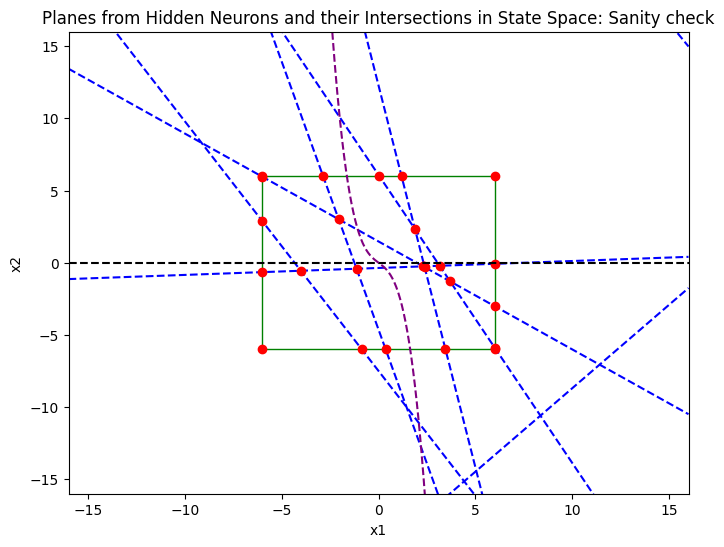

In [15]:
import plotly.graph_objects as go
from plotly.offline import plot

#Now get the weights like we did in my_result, this is for the planes
W_matrix  = duffing_nn.network[0].weight.detach().numpy().T
B_vector  = duffing_nn.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
W_out_vec = duffing_nn.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]


#find a rectangle that contains all the intersection points, these are vertices too
#REGION OF INTEREST
x1_min = -6
x1_max = 6
x2_min = -6
x2_max = 6
intersection_points = find_all_intersection_points(W_matrix, B_vector, [duffing_f1_boundary, duffing_f2_boundary], x1_min, x1_max, x2_min, x2_max)

#get the planar graph 
vertex_dict, edge_list = get_planar_graph(intersection_points, W_matrix, B_vector, x1_min, x1_max, x2_min, x2_max, tol=1e-6)#now make a networkx graph object to use some handy dandy functions
G = nx.Graph()
G.add_nodes_from(vertex_dict.keys())
G.add_edges_from(edge_list)

print(f"Nodes in the graph: {G.nodes()}")
print(f"Edges in the graph: {G.edges()}")

# # Draw the graph to visualize it
# nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
# plt.show()

#plot the regions in R2 defined by all of the planes from the hidden neurons
x1 = np.linspace(x1_min - 10, x1_max + 10, 1000)
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(W_matrix.shape[1]):
    w_i = W_matrix[:, i]
    b_i = B_vector[i]
    x2_plane = (-w_i[0]*x1 - b_i) / w_i[1]
    ax.plot(x1, x2_plane, color='blue', linestyle='--', linewidth=1.5, label=f'Neuron {i+1} Boundary')

    
#plot intersection pts
for i in range(len(intersection_points)):
    # ax.plot(intersection_points[i][0], intersection_points[i][1], 'ro', label=f'Intersection {i+1}')
    ax.plot(intersection_points[i][0], intersection_points[i][1], 'ro', label=f'Intersection {i+1}')
#plot the rectangle containing all the intersection points
rect = plt.Rectangle((x1_min, x2_min), x1_max - x1_min, x2_max - x2_min, linewidth=1, edgecolor='green', facecolor='none', label='Intersection Region')
ax.add_patch(rect)
ax.set_xlim(x1_min -10, x1_max + 10)
ax.set_ylim(x2_min - 10 , x2_max + 10)
#also plot the dynamics boundary of positive and negative
f1_boundary = 0
f2_boundary = duffing_f2_boundary(x1)
ax.plot(x1, f1_boundary * np.ones_like(x1), color='black', linestyle='--', linewidth=1.5, label='$f_1 = 0$')
ax.plot(x1, f2_boundary, color='purple', linestyle='--', linewidth=1.5, label='$f_2 = 0$')
plt.title('Planes from Hidden Neurons and their Intersections in State Space: Sanity check')
plt.xlabel("x1")
plt.ylabel("x2")


# ## Interactive plot (browser)
# fig_i = go.Figure()
# for i in range(W_matrix.shape[1]):
#     w_i = W_matrix[:, i]
#     b_i = B_vector[i]
#     x2_plane = (-w_i[0]*x1 - b_i) / w_i[1]
#     fig_i.add_trace(go.Scatter(x=x1, y=x2_plane, mode='lines', name=f'Neuron {i+1} Boundary'))

# if len(intersection_points) > 0:
#     ix = [p[0] for p in intersection_points]
#     iy = [p[1] for p in intersection_points]
#     fig_i.add_trace(go.Scatter(x=ix, y=iy, mode='markers', name='Intersections', marker=dict(color='red', size=5)))

# fig_i.add_shape(type='rect', x0=x1_min, y0=x2_min, x1=x1_max, y1=x2_max, line=dict(color='green', width=1))
# fig_i.add_trace(go.Scatter(x=x1, y=f1_boundary * np.ones_like(x1), mode='lines', name='f1 = 0', line=dict(color='black', dash='dash')))
# fig_i.add_trace(go.Scatter(x=x1, y=f2_boundary, mode='lines', name='f2 = 0', line=dict(color='purple', dash='dash')))
# fig_i.update_layout(title='Planes from Hidden Neurons and their Intersections (Interactive)', xaxis_title='x1', yaxis_title='x2', width=900, height=700, legend=dict(itemsizing='constant'))
# fig_i.update_xaxes(range=[x1_min - 10, x1_max + 10])
# fig_i.update_yaxes(range=[x2_min - 10, x2_max + 10], scaleanchor='x', scaleratio=1)
# plot(fig_i, filename='duffing_planes.html', auto_open=True)

Number of Nodes:  25
Number of Edges:  40
Number of Polygons Detected:  16


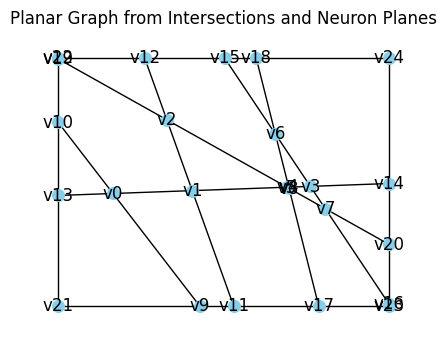

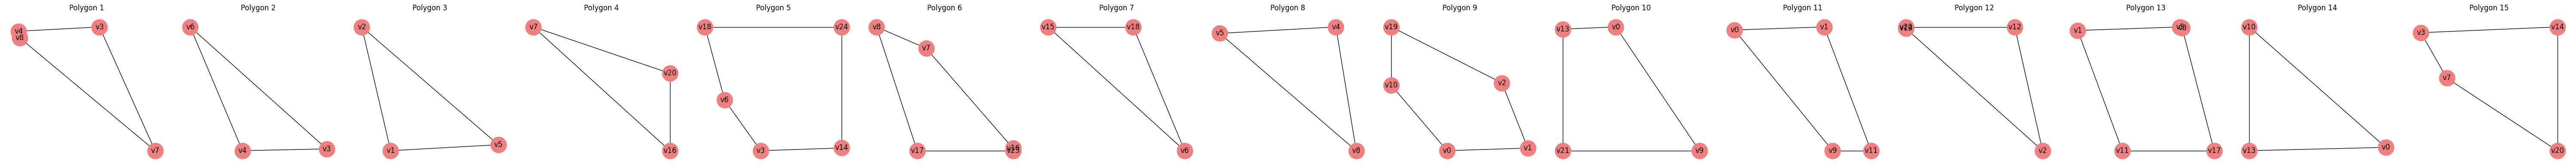

In [16]:
#print original graph
G = nx.Graph()
G.add_nodes_from(vertex_dict.keys())
G.add_edges_from(edge_list)

#get polygons from MCB
polygons = nx.minimum_cycle_basis(G)
#print out some data about the graph
print("Number of Nodes: ", len(G.nodes()))
print("Number of Edges: ", len(G.edges()))
print("Number of Polygons Detected: ", len(polygons))
#first print the orignial graph with all the edges and vertices, use the positions
plt.figure(figsize=(4, 3))
pos = {v: vertex_dict[v] for v in G.nodes()}
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=70, edge_color='k')
plt.title("Planar Graph from Intersections and Neuron Planes")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

#now print some of the polygons to show that this thing works
print_num = 15 #the number of polygons to print
fig, axes = plt.subplots(1, print_num, figsize=(4 * (print_num), 4))
pos = {v: vertex_dict[v] for v in G.nodes()}

for i, nodes in enumerate(polygons[:print_num]):
    subgraph = G.subgraph(nodes)
    nx.draw(subgraph, pos, with_labels=True, node_color='lightcoral', node_size=700, edge_color='k', ax=axes[i])
    axes[i].set_title(f"Polygon {i+1}")
    axes[i].set_xlabel("x1")
    axes[i].set_ylabel("x2")
    axes[i].grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()




In [17]:
def analytic_gradient(model, input_num, hidden_num, x_state):
    #first collect the edges into appropriate matrices to access
    W_matrix  = model.network[0].weight.detach().numpy().T #each column is weights into a hidden neuron [w1, w2,..., wn; w_n+1, ...]
    B_vector  = model.network[0].bias.detach().numpy()  #biases into each hidden neuron [b1, b2, ..., bn]
    W_out_vec = model.network[2].weight.detach().numpy().flatten()  #weights from hidden to output [w_(np+1), ..., wn(p++1)]
    #W_out_vec = W_out_vec[::-1]
    W_out_matrix = np.diag(W_out_vec)  #make into diagonal matrix for for the weird element by element multiplication
    #compute activation vector at x_state: This is a stationary vector for any x_state
    U_vector = np.zeros((hidden_num, 1))
    for i in range(hidden_num):
        w_i = W_matrix[:, i]
        b_i = B_vector[i]
        U_vector[i] = step_function(np.dot(w_i, x_state) + b_i)
    
    grad_vector = np.zeros((input_num, 1))
    for i in range(input_num):
        W_prime = W_out_matrix @ W_matrix[i, :].reshape(-1, 1)
        grad_vector[i] = np.dot(U_vector.T, W_prime)
    return grad_vector

def zero_level_set_crosses_edge(v1, v2, f_function):
    #rind the min and max for x2 on edge
    x1_min = min(v1[0], v2[0])
    x1_max = max(v1[0], v2[0])
    x2_min = min(v1[1], v2[1])
    x2_max = max(v1[1], v2[1])
    
    #in case the interval is big, we want to scale it based on the max distance 
    x1_diff = x1_max - x1_min
    x2_diff = x2_max - x2_min
    refine_steps = max(int(max(x1_diff, x2_diff) * 10), 100)  #at least 50 steps, more if the edge is long
    # Handle vertical edge case separatelty
    if abs(v2[0] - v1[0]) < 1e-10:
        x1_on_edge = np.full(refine_steps, v1[0]) # repeat x1 value for a vector
        x2_on_edge = np.linspace(x2_min, x2_max, refine_steps) # evenly spaced x2 values along the edge
    else:  # non-vertical edge, so jsut do a linear interpolation
        t = np.linspace(0, 1, refine_steps)
        x1_on_edge = v1[0] + t * (v2[0] - v1[0])
        x2_on_edge = v1[1] + t * (v2[1] - v1[1])
    
    # Evaluate function along the edge)
    f_on_edge = np.array([f_function(np.array([[x1], [x2]])) for x1, x2 in zip(x1_on_edge, x2_on_edge)])
    
    # If the sign changes, then the zero level set crosses the edge
    #since the positve and negative regions are crossing the edge as well (thats what we mean by sign change)
    sign_changes = np.where(np.diff(np.sign(f_on_edge)) != 0)[0]
    return True if len(sign_changes) > 0 else False

#given the vertices of a polygon, discretize a grid over it
def is_point_in_polygon(x, y, polygon_vertices):
    # count how many times a horizontal ray to the right from (x,y) intersects polygon edges.
    # If the count is odd => inside, if even => outside
    #  points exactly on an edge return False since it is a boundary
    intersections = 0
    n = len(polygon_vertices)
    for i in range(n):
        xi, yi = polygon_vertices[i]
        xj, yj = polygon_vertices[(i + 1) % n]
        # If there is a vertex above and below horizontal ray from y then maybe intersection
        if (yi > y) != (yj > y):
            # Compute x coordinate of intersection of the edge with the horizontal line y
            xinters = xi + (y - yi) * (xj - xi) / (yj - yi) #see my notes 
            # If the point lies exactly on the edge intersection, treat as outside
            if abs(xinters - x) < 1e-12:
                return False
            # Count intersection only if it is to the right of the point (just need to check one side)
            if xinters > x:
                intersections += 1
    return (intersections % 2) == 1

def discretize_polygon(polygon_vertices, resolution=50):
    x1_coords = [v[0] for v in polygon_vertices]
    x2_coords = [v[1] for v in polygon_vertices]
    x1_min_poly = min(x1_coords)
    x1_max_poly = max(x1_coords)
    x2_min_poly = min(x2_coords)
    x2_max_poly = max(x2_coords)
    #the number of points should also depend on the dimension of the polygon
    #resolution = min(resolution, int(max(x1_max_poly - x1_min_poly, x2_max_poly - x2_min_poly) * 10))
    x1_grid_poly = np.linspace(x1_min_poly, x1_max_poly, resolution)
    x2_grid_poly = np.linspace(x2_min_poly , x2_max_poly , resolution)
    #get rid of first and last ones
    x1_grid_poly = x1_grid_poly[2:-2]
    x2_grid_poly = x2_grid_poly[2:-2]
    X1_poly, X2_poly = np.meshgrid(x1_grid_poly, x2_grid_poly)
    points_in_polygon = []
    for i in range(X1_poly.shape[0]):
        for j in range(X1_poly.shape[1]):
            x1_pt = X1_poly[i, j]
            x2_pt = X2_poly[i, j]
            if is_point_in_polygon(x1_pt, x2_pt, polygon_vertices):
                points_in_polygon.append((x1_pt, x2_pt))
    return points_in_polygon
    

def verify_point(duffing_nn, input_dim, hidden_layer_size, x1_val, x2_val):
    V_nabla = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, np.array([x1_val, x2_val]).reshape(-1, 1))
    f1 = duffing_f1(np.array([[x1_val], [x2_val]]))
    f2 = duffing_f2(np.array([[x1_val], [x2_val]]))
    dot_product = V_nabla[0] * f1 + V_nabla[1] * f2
    if(dot_product >= -1e-10 ): # we found a counterexample
        return False
    else:
        return True # it is negative so we are good to go

def hyperplane_arrangement_NN_verification(duffing_nn, vertex_dict, polygons, input_dim, hidden_layer_size, F_function_list):
    total_points_used = []
    F_function_list = [duffing_f1, duffing_f2]
    counter_examples = []
    #go through each polygon and see if any dynamics functions cross its edges
    for i in range(len(polygons)):
        this_polygon_vertices = polygons[i]
        this_polygon_vertex_coords = [vertex_dict[v] for v in this_polygon_vertices]
        #print("\nThis Polygon: ", this_polygon_vertices)
        split_bool_f1 = False
        split_bool_f2 = False
        #check each consective pair of vertices (each edge of the polygon)
        for j in range(len(this_polygon_vertex_coords)):
            pt1 = this_polygon_vertex_coords[j]
            #wrap around to first point
            pt2 = this_polygon_vertex_coords[(j+1) % len(this_polygon_vertex_coords)] 
            #print(f"Edge from {pt1} to {pt2}")
            #now check each dynamic function to see if it crosses this edge
            for k in range(len(F_function_list)):
                cross_or_not = zero_level_set_crosses_edge(pt1, pt2, F_function_list[k]) # need to make sure this cross, not just touch and go
                if(cross_or_not):
                    if k == 0:
                        split_bool_f1 = True
                if(cross_or_not):
                    if k == 1:
                        split_bool_f2 = True
                
                #if the polygon is crossed by both go ahead and exit early
                if split_bool_f1 and split_bool_f2:
                    break

        if(not split_bool_f1 and not split_bool_f2): #This is the easy case
            #print("EASY CASE: ")
            #not split by either, so we have a nice whole partition
            #get centroid from the vertices
            x1_centroid = np.mean([vertex_dict[v][0] for v in this_polygon_vertices])
            x2_centroid = np.mean([vertex_dict[v][1] for v in this_polygon_vertices])
            total_points_used.append((x1_centroid, x2_centroid))
            check = verify_point(duffing_nn, input_dim, hidden_layer_size, x1_centroid, x2_centroid)
            if(not check): # we found a counterexample
                counter_examples.append((x1_centroid, x2_centroid))
            
        elif(split_bool_f1 != split_bool_f2): #this means that the partition is split by at least one of the zero sets 
            #so now we have to look for a point 
            #print("HARD CASE: Split by one")
            #choose f1 or f2
            if split_bool_f1:
                #print("Split by f1")
                f_function_to_use = duffing_f1
            else:
                #print("Split by f2")
                f_function_to_use = duffing_f2
            #discretize the polygon to find a point in each region
            complete = False
            count = 1
            while not complete: #refine grid if nedded
                points_in_polygon = discretize_polygon(this_polygon_vertex_coords, resolution=50*count)
                #loop through each point until you find one that is in the positive region and one in the negative region for f1
                pos_region_found_f = False
                neg_region_found_f = False
                split_vals = []
                for pt in points_in_polygon:
                    f_value = f_function_to_use(np.array([[pt[0]], [pt[1]]]))
                    if((f_value > 1e-6) and not pos_region_found_f): #only want two values from each partition
                        pos_region_found_f = True
                        split_vals.append(pt)
                    elif((f_value < -1e-6) and not neg_region_found_f):
                        neg_region_found_f = True
                        split_vals.append(pt)
                    if(pos_region_found_f and neg_region_found_f):
                        complete = True
                        break
                count = count + 1
            #now that we have the two points, we can verify
            for i in range(len(split_vals)):
                check = verify_point(duffing_nn, input_dim, hidden_layer_size, split_vals[i][0], split_vals[i][1])
                total_points_used.append((split_vals[i][0], split_vals[i][1]))
                if(not check): # we found a counterexample
                    counter_examples.append((split_vals[i][0], split_vals[i][1]))
            
        elif(split_bool_f1 and split_bool_f2): #then this is the hardest case, could have up to four regions
            #print("HARD CASE: Split by both")
            max_region = 4 # you can have at most
            min_region = 3
            found_count = 0
            split_vals = []
            f_1_list = []
            f_2_list = []
            sign_pairs = set()
            complete = False
            count = 1
            while not complete:
                points_in_polygon = discretize_polygon(this_polygon_vertex_coords, resolution=50 * count)
                #loop through each point, find f1 and f2. Only take new ones that havent been seen in terms of sign
                for pt in points_in_polygon:
                    f_1_val = duffing_f1(np.array([[pt[0]], [pt[1]]]))
                    f_2_val = duffing_f2(np.array([[pt[0]], [pt[1]]]))
                    current_f1_sign = np.sign(f_1_val)
                    current_f2_sign = np.sign(f_2_val)
                    sign_pair = (current_f1_sign, current_f2_sign)
                    #only add if f_1 and f_2 have a new sign combination
                    if sign_pair not in sign_pairs:
                        sign_pairs.add(sign_pair)
                        split_vals.append(pt)
                        f_1_list.append(f_1_val)
                        f_2_list.append(f_2_val)
                        found_count = found_count + 1
                    if((found_count >= max_region) or (found_count >= min_region)):
                        complete = True
                        break
                count = count + 1
            #now we should have found all of the points representing the possible regions
            #verify them 
            for i in range(len(split_vals)):
                check = verify_point(duffing_nn, input_dim, hidden_layer_size, split_vals[i][0], split_vals[i][1])
                total_points_used.append((split_vals[i][0], split_vals[i][1]))
                if(not check): # we found a counterexample
                    counter_examples.append((split_vals[i][0], split_vals[i][1]))
    return counter_examples, total_points_used


In [18]:
#run the hyperplane arrangement method to find counterexamples
counter_examples, total_points_used = hyperplane_arrangement_NN_verification(duffing_nn, vertex_dict, polygons, input_dim, hidden_layer_size, [duffing_f1, duffing_f2])
#go through the list of counterexamples and make sure they do violate it using the autograd for neural network
#this is just confirming that we did find a true counterexample 
for idx, (x1_ce, x2_ce) in enumerate(counter_examples):
    # caste to tensor
    x_state = torch.tensor([[x1_ce, x2_ce]], dtype=torch.float32, requires_grad=True)
    # Get NN output
    V_nn = duffing_nn(x_state)
    # Compute gradient using autograd
    V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
    
    # Evaluate dynamics at this point
    x_state_np = np.array([[x1_ce], [x2_ce]])
    f1_val = duffing_f1(x_state_np)
    f2_val = duffing_f2(x_state_np)
    
    # Compute Lie derivative: dot prodcut of grad V and dynamics vector 
    lie_derivative = V_grad[0, 0].item() * f1_val + V_grad[0, 1].item() * f2_val
    
    # print(f"\nCounterexample {idx + 1}:")
    # print(f"  State: ({x1_ce:.4f}, {x2_ce:.4f})")
    # print(f"  Lie derivative: {lie_derivative:.6f}")
    
    if lie_derivative >= 0:
        #print(f"VIOLATION: Lie derivative is POSITIVE (should be < 0)")
        pass
    else:
        print(f" SOMETHING WRONG: My method found fake counterexample")



num polygons:  16
num points used:  25


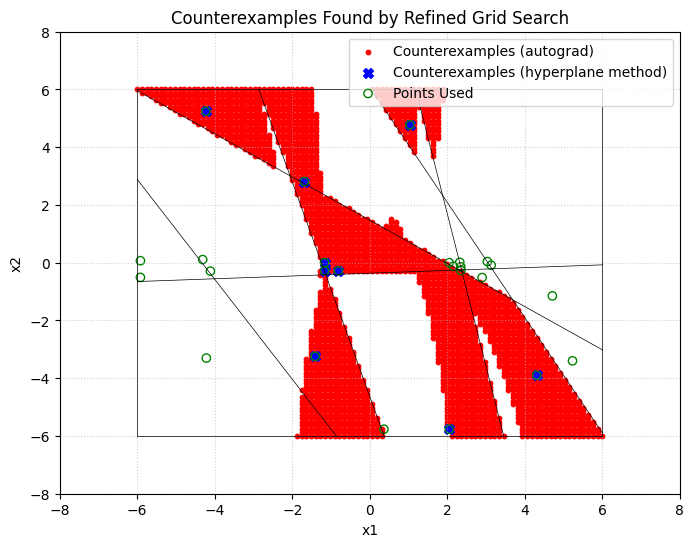

[(2.8985567, -0.51407045), (2.348556883481084, -0.1438847777186608), (2.3225988417255636, 0.013811969027227256), (-1.16676740743676, -0.2777199161295988), (-0.8105700697217668, -0.2777199161295988), (-1.16676740743676, 0.002147372888058996), (5.231223901112874, -3.3983028528637784), (3.131604109884446, -0.08573895015499808), (3.034370350897478, 0.03974020345644519), (4.305621604011695, -3.8974774289865026), (1.0361933084165267, 4.77556586265564), (2.3511517, -0.26918533), (-4.113304897230499, -0.2902627327364389), (-4.3119043817325515, 0.10861906947649924), (-4.218969335155693, -3.3020269671683447), (-1.4104216834041776, -3.2434593737125397), (-4.2298152962335385, 5.242401557940202), (0.3643528942935983, -5.76538790853656), (2.050351608786067, -5.76538790853656), (-5.918837722466916, -0.5076257832078066), (-5.918837722466916, 0.06956682180755558), (4.711731970310211, -1.1472355245865367), (2.0479953454706514, 0.0031800677581709236), (-1.6878710078732546, 2.8102021637011547), (2.1568907

In [19]:
#make a find grid in the box that we called the region of interest, and evaluate the lie derivative at each point to see if we can find any other counterexamples that we missed from the polygons
x1_grid = np.linspace(x1_min, x1_max, 100)
x2_grid = np.linspace(x2_min, x2_max, 100)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
lie_derivative_grid = np.zeros_like(X1)
autograd_counterexamples = []
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x1_pt = X1[i, j]
        x2_pt = X2[i, j]
        x_state = torch.tensor([[x1_pt, x2_pt]], dtype=torch.float32, requires_grad=True)
        V_nn = duffing_nn(x_state)
        V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
        f1_val = duffing_f1(np.array([[x1_pt], [x2_pt]]))
        f2_val = duffing_f2(np.array([[x1_pt], [x2_pt]]))
        lie_derivative_grid[i, j] = V_grad[0, 0].item() * f1_val + V_grad[0, 1].item() * f2_val
        #if a point is positive add it to another counterexample list 
        if lie_derivative_grid[i, j] >= 0:
            autograd_counterexamples.append((x1_pt, x2_pt))

print("num polygons: ", len(polygons))
print("num points used: ", len(total_points_used))
#now make a scatterplot of the autograd counterexamples
if len(autograd_counterexamples) > 0:
    x1_ce_auto = [pt[0] for pt in autograd_counterexamples]
    x2_ce_auto = [pt[1] for pt in autograd_counterexamples]
    plt.figure(figsize=(8, 6))
    plt.scatter(x1_ce_auto, x2_ce_auto, color='red', s=10, label='Counterexamples (autograd)')
    #also plot the counterexamples from the polygons for comparison
    if len(counter_examples) > 0:
        x1_ce_poly = [pt[0] for pt in counter_examples]
        x2_ce_poly = [pt[1] for pt in counter_examples]
        plt.scatter(x1_ce_poly, x2_ce_poly, color='blue', s=50, label='Counterexamples (hyperplane method)', marker='X')
    #plot the points used that were not counterexamples
    x1_all_pts_used = [pt[0] for pt in total_points_used]
    x2_all_pts_used = [pt[1] for pt in total_points_used]
    plt.scatter(x1_all_pts_used, x2_all_pts_used, facecolors = 'none', edgecolors = 'green', label = 'Points Used', marker = 'o')
    #also plot the vertex points for reference, but connect them with edges to see the polygons
    for edge in edge_list:
        v1 = vertex_dict[edge[0]]
        v2 = vertex_dict[edge[1]]
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color='black', linewidth=0.5)
    plt.title('Counterexamples Found by Refined Grid Search')
    plt.xlim(x1_min - 2, x1_max + 2)
    plt.ylim(x2_min - 2, x2_max + 2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print(total_points_used)


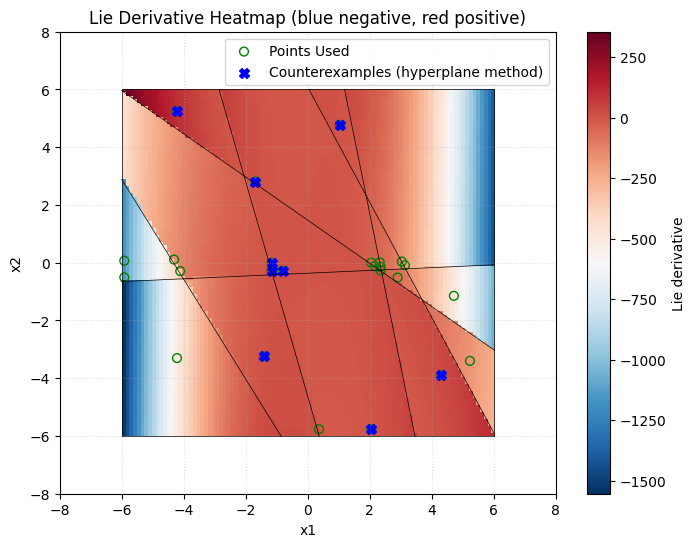

Counterexamples from hyperplane method:


In [20]:
# Heatmap of Lie derivative values over the refined grid
plt.figure(figsize=(8, 6))
# extent = [xmin, xmax, ymin, ymax] so the axes match x1 and x2
extent = [x1_grid.min(), x1_grid.max(), x2_grid.min(), x2_grid.max()]
# show positive (red) and negative (blue) with a diverging colormap
plt.imshow(lie_derivative_grid, origin='lower', extent=extent, aspect='auto', cmap='RdBu_r')
cbar = plt.colorbar()
cbar.set_label('Lie derivative')
# overlay the points used as hollow green circles so you can see points underneath
if 'x1_all_pts_used' in globals():
    plt.scatter(x1_all_pts_used, x2_all_pts_used, facecolors='none', edgecolors='green', marker='o', s=40, linewidths=1.0, label='Points Used')
# overlay polygon edges and counterexamples if present
if 'counter_examples' in globals() and len(counter_examples) > 0:
    x1_ce_poly = [pt[0] for pt in counter_examples]
    x2_ce_poly = [pt[1] for pt in counter_examples]
    plt.scatter(x1_ce_poly, x2_ce_poly, color='blue', s=50, marker='X', label='Counterexamples (hyperplane method)')
if 'edge_list' in globals() and 'vertex_dict' in globals():
    for edge in edge_list:
        v1 = vertex_dict[edge[0]]
        v2 = vertex_dict[edge[1]]
        plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color='black', linewidth=0.5)
plt.xlim(x1_min - 2, x1_max + 2)
plt.ylim(x2_min - 2, x2_max + 2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Lie Derivative Heatmap (blue negative, red positive)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.4)
plt.show()


#there seems to be a lot of counterexamples, so let's see the actual values of the countexamples to see how close to zero they are
print("Counterexamples from hyperplane method:")
for idx, (x1_ce, x2_ce) in enumerate(counter_examples):
    x_state = torch.tensor([[x1_ce, x2_ce]], dtype=torch.float32, requires_grad=True)
    V_nn = duffing_nn(x_state)
    V_grad = torch.autograd.grad(V_nn, x_state, grad_outputs=torch.ones_like(V_nn), create_graph=True)[0]
    f1_val = duffing_f1(np.array([[x1_ce], [x2_ce]]))
    f2_val = duffing_f2(np.array([[x1_ce], [x2_ce]]))
    lie_derivative = V_grad[0, 0].item() * f1_val + V_grad[0, 1].item() * f2_val
    #also use my analytic gradient to compute the lie derivative for comparison
    V_nabla_analytic = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, np.array([x1_ce, x2_ce]).reshape(-1, 1))
    lie_derivative_analytic = V_nabla_analytic[0] * f1_val + V_nabla_analytic[1] * f2_val
    if((lie_derivative < 0) or (lie_derivative_analytic < 0)):
        print(f"Counterexample {idx + 1}: State: ({x1_ce:.4f}, {x2_ce:.4f}), Lie derivative: {lie_derivative:.6f}, Analytic Lie derivative: {lie_derivative_analytic[0]:.6f}")

Number of counterexamples found by analytic gradient:  2656


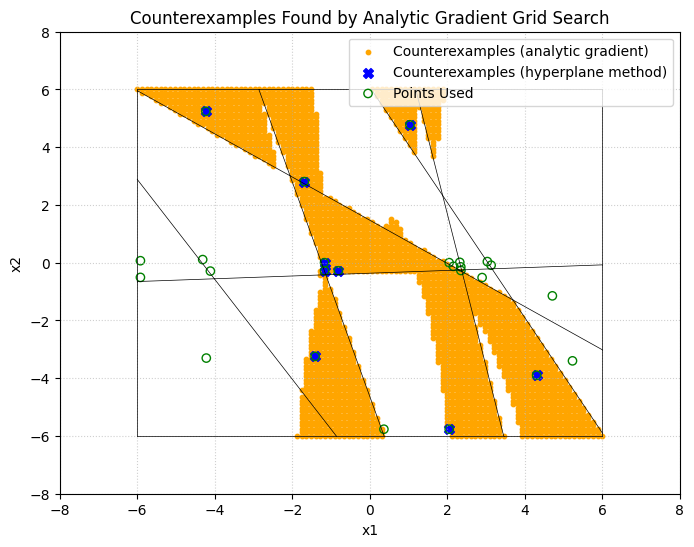

In [21]:
#do the same graph as above but use the analyic gradient instead of autograd to find the counterexamples, this is just to confirm that the analytic gradient is correct and we are not missing any counterexamples from the polygons
analytic_counterexamples = []
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x1_pt = X1[i, j]
        x2_pt = X2[i, j]
        grad_vector = analytic_gradient(duffing_nn, input_dim, hidden_layer_size, np.array([x1_pt, x2_pt]).reshape(-1, 1))
        f1_val = duffing_f1(np.array([[x1_pt], [x2_pt]]))
        f2_val = duffing_f2(np.array([[x1_pt], [x2_pt]]))
        lie_derivative_analytic = grad_vector[0] * f1_val + grad_vector[1] * f2_val
        if lie_derivative_analytic >= 0:
            analytic_counterexamples.append((x1_pt, x2_pt))
print("Number of counterexamples found by analytic gradient: ", len(analytic_counterexamples))
#now make a scatterplot of the analytic counterexamples
if len(analytic_counterexamples) > 0:
    x1_ce_analytic = [pt[0] for pt in analytic_counterexamples]
    x2_ce_analytic = [pt[1] for pt in analytic_counterexamples]
    plt.figure(figsize=(8, 6))
    plt.scatter(x1_ce_analytic, x2_ce_analytic, color='orange', s=10, label='Counterexamples (analytic gradient)')
    #also plot the counterexamples from the polygons for comparison
    if len(counter_examples) > 0:
        x1_ce_poly = [pt[0] for pt in counter_examples]
        x2_ce_poly = [pt[1] for pt in counter_examples]
        plt.scatter(x1_ce_poly, x2_ce_poly, color='blue', s=50, label='Counterexamples (hyperplane method)', marker='X')
    #plot the points used that were not counterexamples
    x1_all_pts_used = [pt[0] for pt in total_points_used]
    x2_all_pts_used = [pt[1] for pt in total_points_used]
    plt.scatter(x1_all_pts_used, x2_all_pts_used, facecolors='none', edgecolors='green', label='Points Used', marker='o')
    #also plot the vertex points for reference, but connect them with edges to see the polygons
    if 'edge_list' in globals() and 'vertex_dict' in globals():
        for edge in edge_list:
            v1 = vertex_dict[edge[0]]
            v2 = vertex_dict[edge[1]]
            plt.plot([v1[0], v2[0]], [v1[1], v2[1]], color='black', linewidth=0.5)
    plt.title('Counterexamples Found by Analytic Gradient Grid Search')
    plt.xlim(x1_min - 2, x1_max + 2)
    plt.ylim(x2_min - 2, x2_max + 2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

In [23]:
# Interactive plot (browser): neuron planes, intersections, points used, and counterexamples
import plotly.graph_objs as go
from plotly.offline import plot
fig_i = go.Figure()
for i in range(W_matrix.shape[1]):
    w_i = W_matrix[:, i]
    b_i = B_vector[i]
    x2_plane = (-w_i[0]*x1 - b_i) / w_i[1]
    fig_i.add_trace(go.Scatter(x=x1, y=x2_plane, mode='lines', name=f'Neuron {i+1} Boundary'))
# intersections
if len(intersection_points) > 0:
    ix = [p[0] for p in intersection_points]
    iy = [p[1] for p in intersection_points]
    fig_i.add_trace(go.Scatter(x=ix, y=iy, mode='markers', name='Intersections', marker=dict(color='red', size=5)))
# add points used and counterexamples
if 'total_points_used' in globals() and len(total_points_used) > 0:
    x1_all_pts_used = [pt[0] for pt in total_points_used]
    x2_all_pts_used = [pt[1] for pt in total_points_used]
    fig_i.add_trace(go.Scatter(x=x1_all_pts_used, y=x2_all_pts_used, mode='markers', name='Points Used', marker=dict(color='green', symbol='circle-open', size=8)))
if 'counter_examples' in globals() and len(counter_examples) > 0:
    x1_ce_poly = [pt[0] for pt in counter_examples]
    x2_ce_poly = [pt[1] for pt in counter_examples]
    fig_i.add_trace(go.Scatter(x=x1_ce_poly, y=x2_ce_poly, mode='markers', name='Counterexamples (hyperplane method)', marker=dict(color='blue', symbol='x', size=10)))
# rectangle region
fig_i.add_shape(type='rect', x0=x1_min, y0=x2_min, x1=x1_max, y1=x2_max, line=dict(color='green', width=1))
# dynamics zero sets - recompute them for the interactive plot to ensure correct values
x1_for_plot = np.linspace(x1_min - 10, x1_max + 10, 1000)
f1_boundary_plot = np.zeros_like(x1_for_plot)  # f1 = x2, so f1=0 means x2=0
f2_boundary_plot = duffing_f2_boundary(x1_for_plot)  # f2=0 boundary
fig_i.add_trace(go.Scatter(x=x1_for_plot, y=f1_boundary_plot, mode='lines', name='f1 = 0', line=dict(color='black', dash='dash')))
fig_i.add_trace(go.Scatter(x=x1_for_plot, y=f2_boundary_plot, mode='lines', name='f2 = 0', line=dict(color='purple', dash='dash')))
fig_i.update_layout(title='Planes from Hidden Neurons and their Intersections (Interactive)', xaxis_title='x1', yaxis_title='x2', width=900, height=700, legend=dict(itemsizing='constant'))
fig_i.update_xaxes(range=[x1_min - 10, x1_max + 10])
fig_i.update_yaxes(range=[x2_min - 10, x2_max + 10], scaleanchor='x', scaleratio=1)
plot(fig_i, filename='duffing_planes.html', auto_open=True)

'duffing_planes.html'